### SYNOPSIS ###

This notebook outlines the process taken to produce relative bias (RB) measurements for the ICARUS detector using results from the DarkSide project in Agnes, P., et al. "Electroluminescence pulse shape and electron diffusion in liquid argon measured in a dual-phase TPC." Nuclear Instruments and Methods in Physics Research Section A: Accelerators, Spectrometers, Detectors and Associated Equipment 904 (2018): 23-34. https://arxiv.org/abs/1802.01427.

The data used is digitized from Figure 15 (a) in the above paper for 140 keV electron recoil events in a 200 V/cm drift field and a 2.8 kV/cm extraction field.

The analysis begin with importing numpy, several matplot features, and lmfit's Model tool for data fitting with constraints.

In [1]:
##########################################
# IMPORTS FOR ANALYSIS AND VISUALIZATION #
##########################################

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

### LIBRARY FOR FITTING TO DATA WITH CONSTRAINTS ###
from lmfit import Model 

### VARIABLES ###

- The cleaning_val variables refer to the highest value in the x axis, which all three data     sets share, that data for the analysis will be includedto remove outliers
- The lower_curve_cleaning variables denote a range of values, between the values of the two     variables, on the x axis of the 150 V/cm data set that are also cleaned
- t_A and t_C are ICARUS specific values for the drift times to reach the anode and cathode in   the detector
- num_of_points_... refers to the number of intermediate points used in the RB calculation       excluding t_C but including t_A and limited by ensuring different wires are sampled by each   intermediate point


In [2]:
##############################################
# VARUABLES USED THROUGHOUT ANALYSIS PROCESS #
##############################################

### VARIABLE FOR RB ANALYSIS ###
cleaning_val_100_V_per_cm = 510
cleaning_val_150_V_per_cm = 460
cleaning_val_200_V_per_cm = 377

lower_curve_cleaning_150_V_per_cm_lower_bound = 6
lower_curve_cleaning_150_V_per_cm_upper_bound = 13

t_A = 92.3
t_C = 851.1 

### CHANGE TO PERSONAL DIRECTORY FOR DATA ###
data_list = ["/home/sebastian/Downloads/Variance_vs_drift_time_100_V_per_cm.csv", 
            "/home/sebastian/Downloads/Variance_vs_drift_time_150_V_per_cm.csv", 
            "/home/sebastian/Downloads/Variance_vs_drift_time_200_V_per_cm.csv"]

num_of_points_excluding_t_C_in_RB_calc = 6

### VARIABLES FOR CHAGRE DENSITY CALCULATION ###
LAr_density = 1.3954
LAr_ionization_energy = 23.6
reco_factor_140keV_200_V_per_cm = 0.319723
stopping_power_140keV_200_V_per_cm = 2.41*(10**6)

### FUNCTIONS ###



This notebook uses the following in its analysis:                                    
- A cleaning function cleaning out data above the variables mentioned above
- A function that fits to the remainined data using a power law plus linear function:    $y=A(x+B)^C+D(x+B)$
- A function to calculate the residuals of each fit 
- Three functions used in the relative bias calculation: y_func, const_linear_fit, and w_func
- A function for calculating the relative bias as t_A changes over a range of values from 92.3   µs to 136.3 µs to ensure sampling from different wires

In [3]:
#############
# FUNCTIONS #
#############

### DATA CLEANING FUNCTION ###
def cleaning_func(input_data):
    data = np.loadtxt(input_data)
    x_axis = data[:,0]
    y_axis = data[:,1]
    x_data_list = []
    y_data_list = []
    if input_data == "/home/sebastian/Downloads/Variance_vs_drift_time_100_V_per_cm.csv":
        for i in np.arange(len(x_axis)):
            if x_axis[i] <= cleaning_val_100_V_per_cm: 
                x_data_list.append(x_axis[i])
                y_data_list.append(y_axis[i])
    if input_data == "/home/sebastian/Downloads/Variance_vs_drift_time_150_V_per_cm.csv":
        for i in np.arange(len(x_axis)):
            if x_axis[i] <= cleaning_val_150_V_per_cm:
                x_data_list.append(x_axis[i])
                y_data_list.append(y_axis[i])
        delete = []
        for i in np.arange(lower_curve_cleaning_150_V_per_cm_lower_bound, lower_curve_cleaning_150_V_per_cm_upper_bound):
            delete.append(i)
        x_data_list = np.delete(x_data_list, delete, 0)
        y_data_list = np.delete(y_data_list, delete, 0)
    if input_data == "/home/sebastian/Downloads/Variance_vs_drift_time_200_V_per_cm.csv":
        for i in np.arange(len(x_axis)):
            if x_axis[i] <= cleaning_val_200_V_per_cm: 
                x_data_list.append(x_axis[i])
                y_data_list.append(y_axis[i])
    x_data = np.array(x_data_list)
    y_data = np.array(y_data_list)
    combined_data_list = [x_data, y_data]
    return combined_data_list

### FITTING FUNCTION USED IN RELATIVE BIAS CALCULATION ###
def data_fitting(x, y):
    def data_fit(t, A, B, C, D):
        return A*(t+B)**(C)+D*(t+B)
    mymodel = Model(data_fit)
    params = mymodel.make_params(A=-0.1, B=0.1, C=-0.1, D=0.1)  
    params['A'].max = 0
    params['C'].max = 0 
    result = mymodel.fit(y, params, t=x)
    print(result.fit_report())
    val1 = result.params['A'].value
    val2 = result.params['B'].value
    val3 = result.params['C'].value
    val4 = result.params['D'].value
    params_list = [val1, val2, val3, val4]
    return params_list

### FINDING RESIDUALS FOR DATA TO DETERMINE FIT QUALITY ###
def residuals_func(input_data_x, input_data_y, a, b, c, d):
    residuals = []
    y_data_fit_len_data = []
    for item in input_data_x:
        y_data_fit_len_data.append(a*(item+b)**(c)+d*(item+b))
    for i in np.arange(len(y_data_fit_len_data)):
        residuals.append(input_data_y[i]-y_data_fit_len_data[i])
    return residuals

### LINEAR PORTION OF FIT AS FUNCTION TO BE USED IN RB CALCULATION ###
def y_func(t, b, d):
    line_result = d*(t+b)
    return line_result
 
### LINEAR FUNCTION WITH NO Y-INT USED IN w_func CALCULATION ###
def const_linear_fit(t, n):
    return n*t

### FUNCTION USED TO FIND LINEAR FUCTION FIT TO 7 POINTS IN ###
### GLOBAL FIT DATA INCLUDING THE t_A AND t_C POINTS ###
def w_func(t, input_time, a, b, c, d):
    var_t_C = a*(t_C+b)**(c)+d*(t_C+b)
    var_t_A = a*(t+b)**(c)+d*(t+b)
    diff = t_C-t 
    delta_t = diff/num_of_points_excluding_t_C_in_RB_calc
    point_1 = t+delta_t
    point_2 = point_1+delta_t
    point_3 = point_2+delta_t
    point_4 = point_3+delta_t
    point_5 = point_4+delta_t
    var_point_1 = a*(point_1+b)**(c)+d*(point_1+b)
    var_point_2 = a*(point_2+b)**(c)+d*(point_2+b)
    var_point_3 = a*(point_3+b)**(c)+d*(point_3+b)
    var_point_4 = a*(point_4+b)**(c)+d*(point_4+b)
    var_point_5 = a*(point_5+b)**(c)+d*(point_5+b)
    RB_data = [var_t_A, var_point_1, var_point_2, var_point_3, var_point_4, var_point_5, var_t_C]
    RB_data_shifted = [var_t_A-var_t_C, var_point_1-var_t_C, var_point_2-var_t_C, var_point_3-var_t_C, var_point_4-var_t_C, var_point_5-var_t_C, var_t_C-var_t_C]
    t_data = [t, point_1, point_2, point_3, point_4, point_5, t_C]
    t_data_shifted = [t-t_C, point_1-t_C, point_2-t_C, point_3-t_C, point_4-t_C, point_5-t_C, t_C-t_C]
    
    mymodel = Model(const_linear_fit)
    params = mymodel.make_params(n=1) 
    result = mymodel.fit(RB_data_shifted, params, t=t_data_shifted)
    val_1 = result.params['n'].value
    
    yint = var_t_C-(val_1)*(t_C)
    w_func_output = val_1*(input_time)+yint
    
    x = []
    y_global = []
    constrained_fit_data = []
    nonconstrained_fit_data = []
    n, m = np.polyfit(t_data, RB_data, 1)
    if input_time == 92.3:
        for i in np.arange(0, t_C+100):
            x.append(i)
            y_global.append(a*(i+b)**(c)+d*(i+b))
            constrained_fit_data.append(val_1*(i)+yint)
            nonconstrained_fit_data.append(n*i+m)
        fig, ax = plt.subplots(1)
        ax.plot(x, y_global, color='blue',  label='Global fit function')
        ax.plot(x, constrained_fit_data, color='red', label='Fit through t_C')
        
        ### OPTION TO PLOT FIT THAT DOESN'T GO THROUGH t_C POINT ###
#         ax.plot(x, nonconstrained_fit_data, label='Fit not constrained through t_C')
        ax.scatter(t, var_t_A, color='black', label='t_A')
        ax.scatter(point_1, var_point_1, color='lightgreen')
        ax.scatter(point_2, var_point_2, color='lightgreen')
        ax.scatter(point_3, var_point_3, color='lightgreen')
        ax.scatter(point_4, var_point_4, color='lightgreen')
        ax.scatter(point_5, var_point_5, color='lightgreen')
        ax.scatter(t_C, var_t_C, color='orange', label='t_C')
        ax.set_xlim(0, 1000)
        ax.set_xlabel('Drift time (μs)')
        ax.set_ylabel('Variance (µs$^2$)')
        ax.legend()

        ### CHECKING TO MAKE SURE LINEAR FIT GOES THROUGH t_C POINT ###
        print('Global fit result at t_C:', var_t_C)
        print('Linear fit result at t_C:', val_1*(t_C)+yint)
    return w_func_output

### RB CALCULATION AS A FUNCTION OF t_A ###
def RB_per_t_A(t):
    RB_fit = []
    V_per_cm_100_RB = []
    V_per_cm_150_RB = []
    V_per_cm_200_RB = []
    
    ### PULLING DATA FOR 100, 150, AND 200 V/CM ###
    for item in data_list:
        data = cleaning_func(item)
        x_data = np.array(data[0])
        y_data = np.array(data[1])
        
        ### DOING POWER LAW PLUS LINEAR FUNCTION FIT ###
        data_fit_params = data_fitting(x_data, y_data)
        t_A_list = []
        
        ### DOING RELATIVE BIAS CALCULATIONS FOR A RANGE OF t_A VALUES KEEPING t_C CONSTANT ###
        ### USING FIT PARAMETERS FOR CALCULATIONS ###
        for i in np.arange(t_A, t, 0.1):
            RB_result = 100*(((w_func(i, t_C, data_fit_params[0], data_fit_params[1], data_fit_params[2], data_fit_params[3])-
                               w_func(i, i, data_fit_params[0], data_fit_params[1], data_fit_params[2], data_fit_params[3]))
                              -(y_func(t_C, data_fit_params[1], data_fit_params[3])
                                -y_func(i, data_fit_params[1], data_fit_params[3])))
                             /(y_func(t_C, data_fit_params[1], data_fit_params[3])-
                               y_func(i, data_fit_params[1], data_fit_params[3])))
            t_A_list.append(i)

            ### STORING CALCLATION RESULTS FOR EACH DATA SET SEPERATELY ###
            if item == data_list[0]:
                V_per_cm_100_RB.append(RB_result)
            if item == data_list[1]:
                V_per_cm_150_RB.append(RB_result)
            if item == data_list[2]:
                V_per_cm_200_RB.append(RB_result)
                
    ### PLOTTING AND PRINTING RESULTS ###
    print('100 V/cm bias:', V_per_cm_100_RB[0])
    print('150 V/cm bias:', V_per_cm_150_RB[0])
    print('200 V/cm bias:', V_per_cm_200_RB[0])
    fig, ax = plt.subplots(1)
    plt.plot(t_A_list, V_per_cm_100_RB, color='blue', label='100 V/cm bias')
    plt.plot(t_A_list, V_per_cm_150_RB, color='darkgreen', label='150 V/cm bias')
    plt.plot(t_A_list, V_per_cm_200_RB, color='red', label='200 V/cm bias')
    plt.xlabel('t_A (μs)')
    plt.ylabel('Relative bias (%)')
    plt.title('Relative bias as a function of t_A')
    plt.legend()
#     plt.savefig('Relative_bias_vs_t_A.pdf')
        

In [4]:
################################################################################
# dQ/dx CALCULATION FOR 140 keV ELECTRON RECOIL EVENTS IN 200 V/cm DRIFT FIELD #
################################################################################

dQdx_200 = (stopping_power_140keV_200_V_per_cm)/(LAr_ionization_energy)*(reco_factor_140keV_200_V_per_cm)*(LAr_density)/(10)

print('dQdx for electrons in 140 keV at 200 V/cm (DarkSide): '+str(dQdx_200)+' e/mm')
print('dQdx for MIPs at 100-500 V/cm (ICARUS): 4000-5500 e/mm')

dQdx for electrons in 140 keV at 200 V/cm (DarkSide): 4555.936240771186 e/mm
dQdx for MIPs at 100-500 V/cm (ICARUS): 4000-5500 e/mm


Text(0.5, 0, '$t_{\\mathrm{drift}}$$+$t0 [µs]')

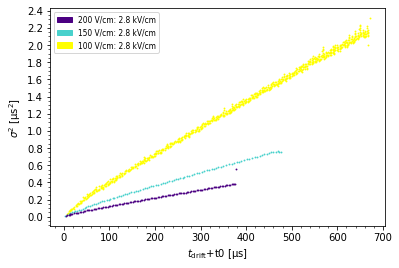

In [6]:
#####################################
# VISUALIZING DATA USED IN ANALYSIS #
#####################################

V_per_cm_100_data = np.loadtxt("/home/sebastian/Downloads/Variance_vs_drift_time_100_V_per_cm.csv")
V_per_cm_150_data = np.loadtxt("/home/sebastian/Downloads/Variance_vs_drift_time_150_V_per_cm.csv")
V_per_cm_200_data = np.loadtxt("/home/sebastian/Downloads/Variance_vs_drift_time_200_V_per_cm.csv")

V_per_cm_100_legend = mpatches.Patch(color='yellow', label='100 V/cm: 2.8 kV/cm')
V_per_cm_150_legend = mpatches.Patch(color='mediumturquoise', label='150 V/cm: 2.8 kV/cm')
V_per_cm_200_legend = mpatches.Patch(color='indigo', label='200 V/cm: 2.8 kV/cm')

x = [0, 700]
y = [0, 2.3]

x_axis_V_per_cm_100 = V_per_cm_100_data[:,0]
y_axis_V_per_cm_100 = V_per_cm_100_data[:,1]

x_axis_V_per_cm_150 = V_per_cm_150_data[:,0]
y_axis_V_per_cm_150 = V_per_cm_150_data[:,1]

x_axis_V_per_cm_200 = V_per_cm_200_data[:,0]
y_axis_V_per_cm_200 = V_per_cm_200_data[:,1]

fig, ax = plt.subplots()
ax.scatter(x_axis_V_per_cm_100, y_axis_V_per_cm_100, color='yellow', s=3, marker='.')
ax.scatter(x_axis_V_per_cm_150, y_axis_V_per_cm_150, color='mediumturquoise', s=3, marker='.')
ax.scatter(x_axis_V_per_cm_200, y_axis_V_per_cm_200, color='indigo', s=3, marker='.')
ax.legend(handles=[V_per_cm_200_legend, V_per_cm_150_legend, V_per_cm_100_legend], fontsize=7.5, loc='upper left')

ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(20))

ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

ax.set_ylabel('$\sigma^2$ [µs$^2$]')
ax.set_xlabel('$t_{\mathrm{drift}}$$+$t0 [µs]')
# fig.savefig('Diffusion_measurement_at_different_drift_fields')

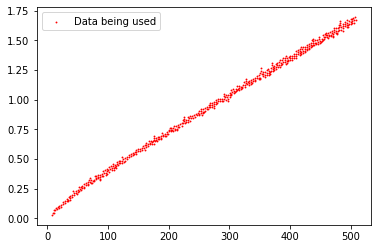

In [7]:
##################################################
# LOOKING AT DATA SETS FOR CLEANING AND ANALYSIS #
##################################################

data = cleaning_func("/home/sebastian/Downloads/Variance_vs_drift_time_100_V_per_cm.csv")

x_data = data[0]
y_data = data[1]

# plt.scatter(x_axis, y_axis, color='blue', marker='.', s=5, label='Data not being used')
plt.scatter(x_data, y_data, color='red', marker='.', s=3, label='Data being used')
plt.legend()
# plt.savefig('Data_cleaning')

[[Model]]
    Model(data_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 496
    # variables        = 4
    chi-square         = 0.15253024
    reduced chi-square = 3.1002e-04
    Akaike info crit   = -4003.13630
    Bayesian info crit = -3986.31000
    R-squared          = 0.99855922
[[Variables]]
    A: -9.40541599 +/- 4.86302578 (51.70%) (init = -0.1)
    B:  49.9604061 +/- 6.16373639 (12.34%) (init = 0.1)
    C: -1.04151243 +/- 0.16954862 (16.28%) (init = -0.1)
    D:  0.00304260 +/- 2.3466e-05 (0.77%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, C) = 0.979
    C(B, D) = -0.978
    C(B, C) = 0.929
    C(C, D) = -0.844
    C(A, B) = 0.836
    C(A, D) = -0.724


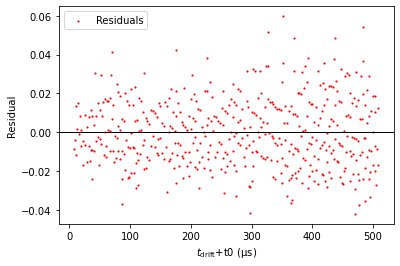

In [8]:
######################
# PLOTTING RESIDUALS #
######################

data = cleaning_func("/home/sebastian/Downloads/Variance_vs_drift_time_100_V_per_cm.csv")
x = data[0]
y = data[1]

fitting_params = data_fitting(x, y)

plt.scatter(x, residuals_func(x, y, fitting_params[0], fitting_params[1], fitting_params[2], fitting_params[3]), color='red', marker='.', s=5, label='Residuals')
plt.legend()
plt.xlabel('$t_{\mathrm{drift}}$$+$t0 (µs)')
plt.ylabel('Residual')
plt.axhspan(0, 0, color="black")
# plt.savefig('Residuals_v_time_100.pdf')

[[Model]]
    Model(data_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 496
    # variables        = 4
    chi-square         = 0.15253024
    reduced chi-square = 3.1002e-04
    Akaike info crit   = -4003.13630
    Bayesian info crit = -3986.31000
    R-squared          = 0.99855922
[[Variables]]
    A: -9.40541599 +/- 4.86302578 (51.70%) (init = -0.1)
    B:  49.9604061 +/- 6.16373639 (12.34%) (init = 0.1)
    C: -1.04151243 +/- 0.16954862 (16.28%) (init = -0.1)
    D:  0.00304260 +/- 2.3466e-05 (0.77%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, C) = 0.979
    C(B, D) = -0.978
    C(B, C) = 0.929
    C(C, D) = -0.844
    C(A, B) = 0.836
    C(A, D) = -0.724
Global fit result at t_C: 2.7336999082921682
Linear fit result at t_C: 2.7336999082921682
[[Model]]
    Model(data_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 62
    # data points      = 88
    # v

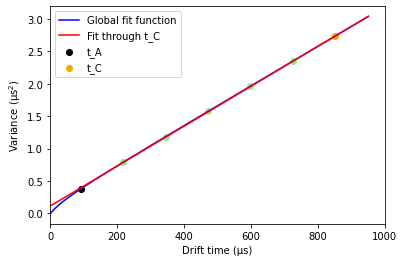

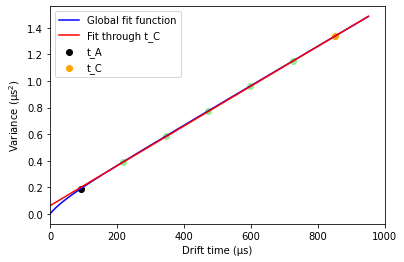

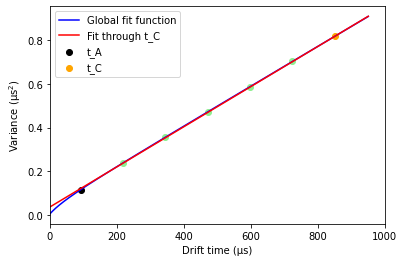

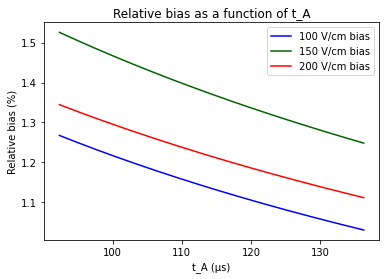

In [9]:
#############################
# RELATIVE BIAS CALCULATION #
#############################

### CALCULATING RB AS A FUNCTION OF t_A FROM t_A EQUAL TO 92.3 MICROSEC TO 136.3 MICROSEC ###
run_analysis = RB_per_t_A(t_A+44)